In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline
from scipy import stats
import shap

import warnings
warnings.filterwarnings("ignore")

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.inprocessing.prejudice_remover import PrejudiceRemover
from aif360.algorithms.preprocessing import DisparateImpactRemover

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

In [3]:
#Functions

def consitency_mod(metric, col,n_neighbors=5):
    #Function to calculate consistency
    X = metric.dataset.features
    X = np.delete(X, col, 1)
    X = StandardScaler().fit_transform(X) 
    num_samples = X.shape[0]
    y = metric.dataset.labels

    # learn a KNN on the features
    nbrs = NearestNeighbors(n_neighbors, algorithm='ball_tree').fit(X)
    _, indices = nbrs.kneighbors(X)

    # compute consistency score
    consistency = 0.0
    for i in range(num_samples):
        consistency += np.abs(y[i] - np.mean(y[indices[i]]))
    consistency = 1.0 - consistency/num_samples

    return consistency

## Loading data

In [5]:
path = ''
df_original = pd.read_csv(path + 'data/adult.data', header=None)
df_original.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]
print(df_original.shape)
df_original.head()

(32561, 15)


,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocessing

In [6]:
columns_cat = ['WorkClass', 'Education', 'MaritalStatus', 'Occupation', 
               'Relationship', 'NativeCountry', 'Income', 'Race', 'Gender']

for col_cat in columns_cat:
    df_original[col_cat] = df_original[col_cat].str.strip()

In [7]:
df_proces = df_original.copy()

df_proces['Race'] = df_proces['Race'].apply(lambda row: 1 if row == 'White' else 0)
df_proces['Gender'] = df_proces['Gender'].apply(lambda row: 1 if row == 'Male' else 0)
df_proces['Income'] = df_proces['Income'].apply(lambda row: 0 if row == '<=50K' else 1)

columns_cat = ['WorkClass', 'Education', 'MaritalStatus', 'Occupation', 
               'Relationship', 'NativeCountry']

lb_encoder = LabelEncoder()
for col_cat in columns_cat:  
    df_proces[col_cat] = lb_encoder.fit_transform(df_proces[col_cat])

df_proces.drop(['fnlwgt'], axis=1, inplace=True)
df_proces = df_proces.astype(float)
df_proces.head()

,Age,WorkClass,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39.0,7.0,9.0,13.0,4.0,1.0,1.0,1.0,1.0,2174.0,0.0,40.0,39.0,0.0
1,50.0,6.0,9.0,13.0,2.0,4.0,0.0,1.0,1.0,0.0,0.0,13.0,39.0,0.0
2,38.0,4.0,11.0,9.0,0.0,6.0,1.0,1.0,1.0,0.0,0.0,40.0,39.0,0.0
3,53.0,4.0,1.0,7.0,2.0,6.0,0.0,0.0,1.0,0.0,0.0,40.0,39.0,0.0
4,28.0,4.0,9.0,13.0,2.0,10.0,5.0,0.0,0.0,0.0,0.0,40.0,5.0,0.0


In [8]:
for col_cat in columns_cat:  
    one_hot = OneHotEncoder(sparse=False)
    res = one_hot.fit_transform(df_proces[[col_cat]])
    num_col = res.shape[1]
    for idx in range(num_col):
        df_proces['{}_{}'.format(col_cat, idx)] = res[:, idx]
        
df_proces.drop(columns_cat, axis=1, inplace=True)
df_proces.head()

,Age,EducationNum,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,Income,WorkClass_0,WorkClass_1,...,NativeCountry_32,NativeCountry_33,NativeCountry_34,NativeCountry_35,NativeCountry_36,NativeCountry_37,NativeCountry_38,NativeCountry_39,NativeCountry_40,NativeCountry_41
0,39.0,13.0,1.0,1.0,2174.0,0.0,40.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,50.0,13.0,1.0,1.0,0.0,0.0,13.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,38.0,9.0,1.0,1.0,0.0,0.0,40.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,53.0,7.0,0.0,1.0,0.0,0.0,40.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28.0,13.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
metadata = {'label_maps': [{0.0: '<=50K', 1.0: '>50K'}], 
            'protected_attribute_maps': [{0.0: 'Non-white', 1.0: 'White'}]}
unprivileged_groups=[{'Race': [0.0]}]
privileged_groups=[{'Race': [1.0]}]
protected_attribute_names = ['Race']
label_names = ['Income']
dataset = BinaryLabelDataset(df = df_proces, label_names=label_names, 
                            protected_attribute_names = protected_attribute_names, 
                            instance_weights_name=None, unprivileged_protected_attributes=[], 
                            privileged_protected_attributes=[], metadata=metadata)

metric_orig = BinaryLabelDatasetMetric(dataset,
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)
disparate_impact_orig = metric_orig.disparate_impact()
print('Disparate impact dados originais: ', (1 - disparate_impact_orig))
position = 2

Disparate impact dados originais:  0.4036515960167799


In [0]:
lst_res = []

## Model with original data

In [0]:
dataset_train, dataset_test = dataset.split([0.7], shuffle=False)

scale = StandardScaler().fit(dataset_train.features)   
X_train_orig = scale.transform(dataset_train.features)   
y_train = dataset_train.labels.ravel()
X_test_orig = scale.transform(dataset_test.features)
y_test = dataset_test.labels.ravel()

### Random Forest

In [17]:
model_orig_rf = RandomForestClassifier()
model_orig_rf.fit(X_train_orig, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
y_pred_test = model_orig_rf.predict(X_test_orig)
acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Acuracia teste: ", acc_test)
y_pred_train = model_orig_rf.predict(X_train_orig)
acc_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print("Acuracia treino: ", acc_train)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

metric_orig_pred_rf = BinaryLabelDatasetMetric(dataset_pred,
                                           unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)
disparate_impact_orig_pred_rf = metric_orig_pred_rf.disparate_impact()
print('Disparate impact previsão com dados originais: ', (1 - disparate_impact_orig_pred_rf))
mean_difference_orig_pred_rf = metric_orig_pred_rf.mean_difference()
print('Mean difference previsão com dados originais: ', mean_difference_orig_pred_rf)

classif_metric_orig_pred_rf = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
classif_disparete_impact_orig_pred_rf = classif_metric_orig_pred_rf.disparate_impact()
print('Classif. disparete previsão com dados originais', 1 - classif_disparete_impact_orig_pred_rf)
avg_odds_orig_pred_rf = classif_metric_orig_pred_rf.average_odds_difference()
print('average_odds_difference previsão com dados originais:', avg_odds_orig_pred_rf)
equal_opport_orig_pred_rf = classif_metric_orig_pred_rf.equal_opportunity_difference()
print('equal_opportunity_difference previsão com dados originais:', equal_opport_orig_pred_rf)
false_discovery_rate_orig_pred_rf = classif_metric_orig_pred_rf.false_discovery_rate_difference()
print('false_discovery_rate_difference previsão com dados originais:', false_discovery_rate_orig_pred_rf)
cons_comp_orig_pred_rf = consitency_mod(metric_orig_pred_rf, position,n_neighbors=5)
print('Consistency comparative: ', cons_comp_orig_pred_rf)

entropy_index_orig_pred_rf = classif_metric_orig_pred_rf.generalized_entropy_index()
print('generalized_entropy_index previsão com dados originais:', entropy_index_orig_pred_rf)

lst_res.append(('adult', 'rf_orig', acc_test, 1-disparate_impact_orig_pred_rf, mean_difference_orig_pred_rf,
                1 - classif_disparete_impact_orig_pred_rf, avg_odds_orig_pred_rf, equal_opport_orig_pred_rf,
                false_discovery_rate_orig_pred_rf, entropy_index_orig_pred_rf, cons_comp_orig_pred_rf))

Acuracia teste:  0.8437915856280069
Acuracia treino:  0.9678834678834679
Disparate impact previsão com dados originais:  0.3913537186634387
Mean difference previsão com dados originais:  -0.08759966092394406
Classif. disparete previsão com dados originais 0.3913537186634387
average_odds_difference previsão com dados originais: -0.0365853869747214
equal_opportunity_difference previsão com dados originais: -0.04108235670573179
false_discovery_rate_difference previsão com dados originais: 0.047608927252861644
Consistency comparative:  0.8849831098372385
generalized_entropy_index previsão com dados originais: 0.08324357731356714


### Logistic Regression

In [19]:
model_orig_lr = LogisticRegression()
model_orig_lr.fit(X_train_orig, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [20]:
y_pred_test = model_orig_lr.predict(X_test_orig)
acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Acuracia teste: ", acc_test)
y_pred_train = model_orig_lr.predict(X_train_orig)
acc_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print("Acuracia treino: ", acc_train)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

metric_orig_pred_lr = BinaryLabelDatasetMetric(dataset_pred,
                                           unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)
disparate_impact_orig_pred_lr = metric_orig_pred_lr.disparate_impact()
print('Disparate impact previsão com dados originais: ', (1 - disparate_impact_orig_pred_lr))
mean_difference_orig_pred_lr = metric_orig_pred_lr.mean_difference()
print('Mean difference previsão com dados originais: ', mean_difference_orig_pred_lr)

classif_metric_orig_pred_lr = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
classif_disparete_impact_orig_pred_lr = classif_metric_orig_pred_lr.disparate_impact()
print('Classif. disparete previsão com dados originais', 1 - classif_disparete_impact_orig_pred_lr)
avg_odds_orig_pred_lr = classif_metric_orig_pred_lr.average_odds_difference()
print('average_odds_difference previsão com dados originais:', avg_odds_orig_pred_lr)
equal_opport_orig_pred_lr = classif_metric_orig_pred_lr.equal_opportunity_difference()
print('equal_opportunity_difference previsão com dados originais:', equal_opport_orig_pred_lr)
false_discovery_rate_orig_pred_lr = classif_metric_orig_pred_lr.false_discovery_rate_difference()
print('false_discovery_rate_difference previsão com dados originais:', false_discovery_rate_orig_pred_lr)

cons_comp_orig_pred_lr = consitency_mod(metric_orig_pred_lr, position,n_neighbors=5)
print('Consistency comparative: ', cons_comp_orig_pred_lr)

entropy_index_orig_pred_lr = classif_metric_orig_pred_lr.generalized_entropy_index()
print('generalized_entropy_index previsão com dados originais:', entropy_index_orig_pred_lr)

lst_res.append(('adult', 'lr_orig', acc_test, 1-disparate_impact_orig_pred_lr, mean_difference_orig_pred_lr,
                1 - classif_disparete_impact_orig_pred_lr, avg_odds_orig_pred_lr, equal_opport_orig_pred_lr,
                false_discovery_rate_orig_pred_lr, entropy_index_orig_pred_lr, cons_comp_orig_pred_lr))

Acuracia teste:  0.8520831200737026
Acuracia treino:  0.8512636012636012
Disparate impact previsão com dados originais:  0.4250545686376209
Mean difference previsão com dados originais:  -0.0915172157874104
Classif. disparete previsão com dados originais 0.4250545686376209
average_odds_difference previsão com dados originais: -0.04144151042799692
equal_opportunity_difference previsão com dados originais: -0.04885804567817287
false_discovery_rate_difference previsão com dados originais: 0.018720695331205073
Consistency comparative:  0.9399529122735184
generalized_entropy_index previsão com dados originais: 0.07990232225240083


## Model with transformed data

In [0]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
RW.fit(dataset_train)
dataset_transf_train = RW.transform(dataset_train)

In [22]:
metric_transf = BinaryLabelDatasetMetric(dataset_transf_train,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
disparate_impact_transf = metric_transf.disparate_impact()
print('Disparate impact dados transformados: ', (1 - disparate_impact_transf))

Disparate impact dados transformados:  3.3306690738754696e-16


In [0]:
scale_transf = StandardScaler().fit(dataset_transf_train.features) 
X_train_transf = scale.transform(dataset_transf_train.features)  
y_train = dataset_transf_train.labels.ravel()
X_test_transf = scale_transf.transform(dataset_test.features) 
y_test = dataset_test.labels.ravel()

### Random Forest

In [24]:
model_transf_rf = RandomForestClassifier()
model_transf_rf.fit(X_train_transf, y_train,
                 sample_weight=dataset_transf_train.instance_weights)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
y_pred_test = model_transf_rf.predict(X_test_transf)

acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Acuracia teste: ", acc_test)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

metric_pred_transf_rf = BinaryLabelDatasetMetric(dataset_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
disparate_impact_transf_pred_rf = metric_pred_transf_rf.disparate_impact()
mean_difference_transf_pred_rf = metric_pred_transf_rf.mean_difference()
print('Disparate impact previsão com dados transformados: ', (1 - disparate_impact_transf_pred_rf))
print('Mean difference previsão com dados transformados: ', mean_difference_transf_pred_rf)

classif_metric_transf_pred_rf = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
classif_disparete_impact_transf_pred_rf = classif_metric_transf_pred_rf.disparate_impact()
print('Classif. disparete previsão com dados transformados', 1 - classif_disparete_impact_transf_pred_rf)
avg_odds_transf_pred_rf = classif_metric_transf_pred_rf.average_odds_difference()
print('average_odds_difference previsão com dados transformados:', avg_odds_transf_pred_rf)
equal_opport_transf_pred_rf = classif_metric_transf_pred_rf.equal_opportunity_difference()
print('equal_opportunity_difference previsão com dados transformados:', equal_opport_transf_pred_rf)
false_discovery_rate_transf_pred_rf = classif_metric_transf_pred_rf.false_discovery_rate_difference()
print('false_discovery_rate_difference previsão com dados transformados:', 
      false_discovery_rate_transf_pred_rf)
cons_comp_transf_pred_rf = consitency_mod(metric_pred_transf_rf, position,n_neighbors=5)
print('Consistency comparative: ', cons_comp_transf_pred_rf)

entropy_index_transf_pred_rf = classif_metric_transf_pred_rf.generalized_entropy_index()
print('generalized_entropy_index previsão com dados transformados:', entropy_index_transf_pred_rf)

lst_res.append(('adult', 'rf_transf', acc_test, 1-disparate_impact_transf_pred_rf, 
                mean_difference_transf_pred_rf, 1 - classif_disparete_impact_transf_pred_rf,
                avg_odds_transf_pred_rf, equal_opport_transf_pred_rf,
                false_discovery_rate_transf_pred_rf, entropy_index_transf_pred_rf, cons_comp_transf_pred_rf))


Acuracia teste:  0.8434844917596479
Disparate impact previsão com dados transformados:  0.41978277878514825
Mean difference previsão com dados transformados:  -0.09406402528346766
Classif. disparete previsão com dados transformados 0.41978277878514825
average_odds_difference previsão com dados transformados: -0.04735091150530524
equal_opportunity_difference previsão com dados transformados: -0.058013679452821876
false_discovery_rate_difference previsão com dados transformados: 0.0355028235696766
Consistency comparative:  0.8815231855870591
generalized_entropy_index previsão com dados transformados: 0.08350514715408996


### Logistic Regression

In [26]:
model_transf_lr = LogisticRegression()
model_transf_lr.fit(X_train_transf, y_train,
                    sample_weight=dataset_transf_train.instance_weights)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [27]:
y_pred_test = model_transf_lr.predict(X_test_transf)

acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Acuracia teste: ", acc_test)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

metric_pred_transf_lr = BinaryLabelDatasetMetric(dataset_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
disparate_impact_transf_pred_lr = metric_pred_transf_lr.disparate_impact()
mean_difference_transf_pred_lr = metric_pred_transf_lr.mean_difference()
print('Disparate impact previsão com dados transformados: ', (1 - disparate_impact_transf_pred_lr))
print('Mean difference previsão com dados transformados: ', mean_difference_transf_pred_lr)

classif_metric_transf_pred_lr = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
classif_disparete_impact_transf_pred_lr = classif_metric_transf_pred_lr.disparate_impact()
print('Classif. disparete previsão com dados transformados', 1 - classif_disparete_impact_transf_pred_lr)
avg_odds_transf_pred_lr = classif_metric_transf_pred_lr.average_odds_difference()
print('average_odds_difference previsão com dados transformados:', avg_odds_transf_pred_lr)
equal_opport_transf_pred_lr = classif_metric_transf_pred_lr.equal_opportunity_difference()
print('equal_opportunity_difference previsão com dados transformados:', equal_opport_transf_pred_lr)
false_discovery_rate_transf_pred_lr = classif_metric_transf_pred_lr.false_discovery_rate_difference()
print('false_discovery_rate_difference previsão com dados transformados:', false_discovery_rate_transf_pred_lr)
cons_comp_transf_pred_lr = consitency_mod(metric_pred_transf_lr, position,n_neighbors=5)
print('Consistency comparative: ', cons_comp_transf_pred_lr)

entropy_index_transf_pred_lr = classif_metric_transf_pred_lr.generalized_entropy_index()
print('generalized_entropy_index previsão com dados transformados:', entropy_index_transf_pred_lr)

lst_res.append(('adult', 'lr_transf', acc_test, 1-disparate_impact_transf_pred_lr, 
                mean_difference_transf_pred_lr, 1 - classif_disparete_impact_transf_pred_lr, 
                avg_odds_transf_pred_lr, equal_opport_transf_pred_lr,
                false_discovery_rate_transf_pred_lr, entropy_index_transf_pred_lr, cons_comp_transf_pred_lr))

Acuracia teste:  0.8511618384686253
Disparate impact previsão com dados transformados:  0.17387804346434532
Mean difference previsão com dados transformados:  -0.03566139855744774
Classif. disparete previsão com dados transformados 0.17387804346434532
average_odds_difference previsão com dados transformados: 0.057766199893940905
equal_opportunity_difference previsão com dados transformados: 0.11623935042598299
false_discovery_rate_difference previsão com dados transformados: 0.08923400643209833
Consistency comparative:  0.9358173815129491
generalized_entropy_index previsão com dados transformados: 0.08063810759585055


In [0]:
cols_name = ['dataset', 'name_exp', 'acc_test', '1_disp_impact_bin', 'mean_difference',
             '1_disp_impact_clf', 'avg_odds', 'equal_opport', 'false_discovery_rate',
             'entropy_index', 'consistency']

df_final = pd.DataFrame(lst_res, columns=cols_name)

In [29]:
df_final

,dataset,name_exp,acc_test,1_disp_impact_bin,mean_difference,1_disp_impact_clf,avg_odds,equal_opport,false_discovery_rate,entropy_index,consistency
0,adult,rf_orig,0.843792,0.391354,-0.087600,0.391354,-0.036585,-0.041082,0.047609,0.083244,0.884983
1,adult,lr_orig,0.852083,0.425055,-0.091517,0.425055,-0.041442,-0.048858,0.018721,0.079902,0.939953
2,adult,rf_transf,0.843484,0.419783,-0.094064,0.419783,-0.047351,-0.058014,0.035503,0.083505,0.881523
3,adult,lr_transf,0.851162,0.173878,-0.035661,0.173878,0.057766,0.116239,0.089234,0.080638,0.935817


## SHAP

In [30]:
df_proces.columns[2]

'Race'

### Random Forest

In [0]:
lst_shape = []
position = 2
name_protect = 'Race'

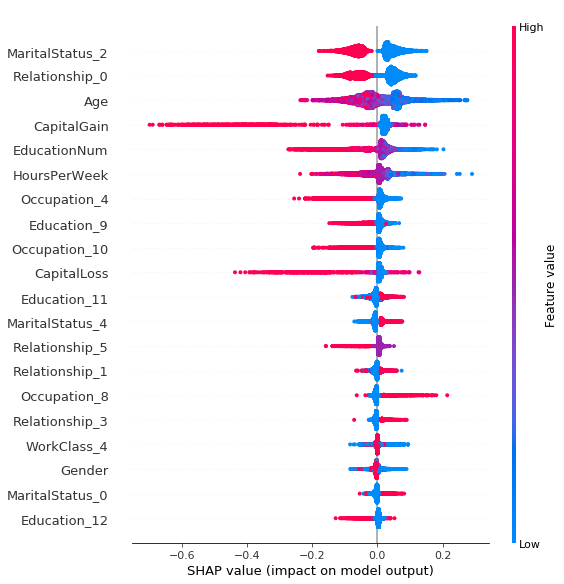

In [32]:
exp_transf = shap.TreeExplainer(model_transf_rf, X_train_transf)
shap_values_transf = exp_transf.shap_values(X_test_transf)
shap.summary_plot(shap_values_transf[0], X_test_transf, feature_names=dataset.feature_names)

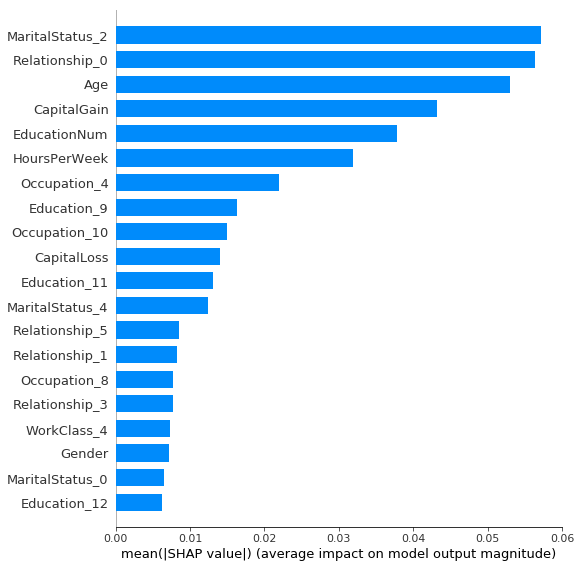

In [33]:
shap.summary_plot(shap_values_transf[0], X_test_transf, feature_names=dataset.feature_names, plot_type="bar")


In [34]:
df_feat = pd.DataFrame({'feature_names': dataset.feature_names, 
                        'value': np.abs(shap_values_transf[0]).mean(axis=0)})
df_feat = df_feat.sort_values(by='value', ascending=False).reset_index(drop=True)
feat_import_transf_rf = df_feat.loc[df_feat['feature_names'] == name_protect, 'value'].iloc[0]
pos_transf_rf = df_feat[df_feat['feature_names'] == name_protect].index[0]
df_feat

,feature_names,value
0,MaritalStatus_2,5.714525e-02
1,Relationship_0,5.637055e-02
2,Age,5.299042e-02
3,CapitalGain,4.314716e-02
4,EducationNum,3.779476e-02
5,HoursPerWeek,3.184496e-02
6,Occupation_4,2.200262e-02
7,Education_9,1.629895e-02
8,Occupation_10,1.493418e-02
9,CapitalLoss,1.398791e-02


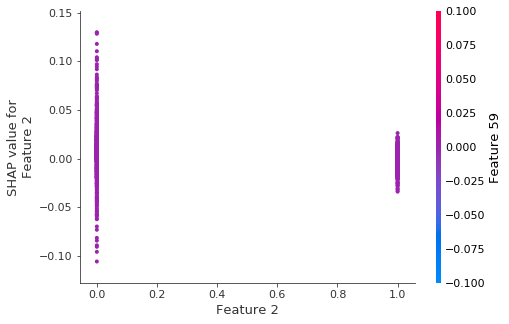

In [35]:
shap.dependence_plot(position, shap_values_transf[0], dataset_test.features)

In [36]:
df = pd.DataFrame({'shap': shap_values_transf[0][:, position], 
                   'feat_value': dataset_test.features[:, position]})
unp_value_transf_rf = df.loc[df['feat_value'] == 0, 'shap'].mean()
priv_value_transf_rf = df.loc[df['feat_value'] == 1, 'shap'].mean()
print('Media valores SHAP classe não priveligiada: ', unp_value_transf_rf)
print('Media valores SHAP classe priveligiada: ', priv_value_transf_rf)

Media valores SHAP classe não priveligiada:  0.008076982365605688
Media valores SHAP classe priveligiada:  -0.0015207478988693468


In [37]:
results = stats.ttest_ind(df.loc[df['feat_value'] == 1, 'shap'], 
                          df.loc[df['feat_value'] == 0, 'shap'], equal_var=False)

alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad")
    priv_greater_unpriv = 1
else:
    print("accept null hypothesis")
    priv_greater_unpriv = 0

accept null hypothesis


In [0]:
lst_shape.append(('rf_transf', feat_import_transf_rf, pos_transf_rf,unp_value_transf_rf, 
                  priv_value_transf_rf, priv_greater_unpriv))

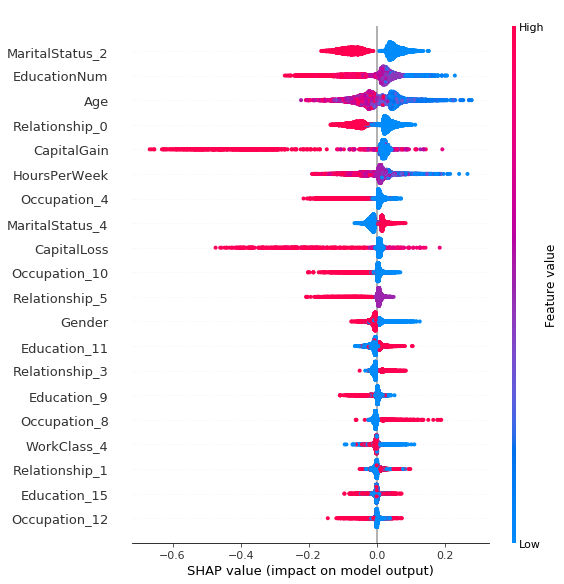

In [39]:
exp_orig = shap.TreeExplainer(model_orig_rf, X_train_orig)
shap_values_orig = exp_orig.shap_values(X_test_orig)
shap.summary_plot(shap_values_orig[0], X_test_orig, feature_names=dataset.feature_names)

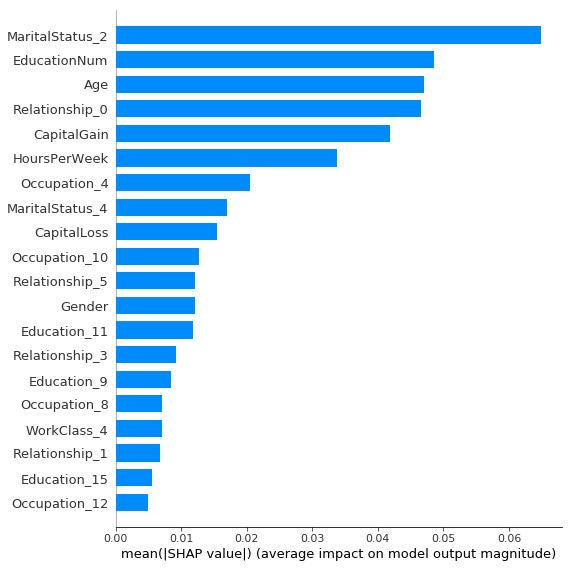

In [40]:
shap.summary_plot(shap_values_orig[0], X_test_orig, feature_names=dataset.feature_names, plot_type="bar")

In [41]:
df_feat = pd.DataFrame({'feature_names': dataset.feature_names, 
                        'value': np.abs(shap_values_orig[0]).mean(axis=0)})
df_feat = df_feat.sort_values(by='value', ascending=False).reset_index(drop=True)
feat_import_orig_rf = df_feat.loc[df_feat['feature_names'] == name_protect, 'value'].iloc[0]
pos_orig_rf = df_feat[df_feat['feature_names'] == name_protect].index[0]
df_feat

,feature_names,value
0,MaritalStatus_2,6.486503e-02
1,EducationNum,4.862265e-02
2,Age,4.699106e-02
3,Relationship_0,4.662092e-02
4,CapitalGain,4.189337e-02
5,HoursPerWeek,3.381372e-02
6,Occupation_4,2.054979e-02
7,MaritalStatus_4,1.703452e-02
8,CapitalLoss,1.538009e-02
9,Occupation_10,1.277715e-02


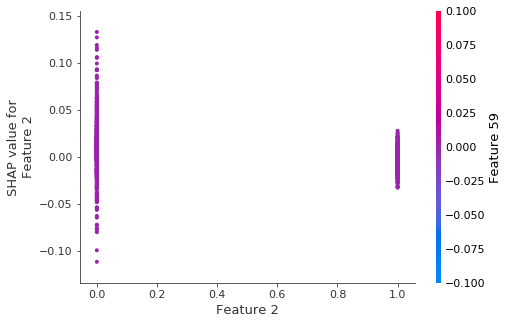

In [42]:
shap.dependence_plot(position, shap_values_orig[0], dataset_test.features)

In [43]:
df = pd.DataFrame({'shap': shap_values_orig[0][:, position], 
                   'feat_value': dataset_test.features[:, position]})
unp_value_orig_rf = df.loc[df['feat_value'] == 0, 'shap'].mean()
priv_value_orig_rf = df.loc[df['feat_value'] == 1, 'shap'].mean()
print('Media valores SHAP classe não priveligiada: ', unp_value_orig_rf)
print('Media valores SHAP classe priveligiada: ', priv_value_orig_rf)

Media valores SHAP classe não priveligiada:  0.008153037011238599
Media valores SHAP classe priveligiada:  -0.0015540679799432072


In [44]:
results = stats.ttest_ind(df.loc[df['feat_value'] == 1, 'shap'], 
                          df.loc[df['feat_value'] == 0, 'shap'], equal_var=False)

alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad")
    priv_greater_unpriv = 1
else:
    print("accept null hypothesis")
    priv_greater_unpriv = 0

accept null hypothesis


In [0]:
lst_shape.append(('rf_orig', feat_import_orig_rf, pos_orig_rf, 
                  unp_value_orig_rf, priv_value_orig_rf, priv_greater_unpriv))

In [46]:
prop_feat_import_rf = (feat_import_orig_rf - feat_import_transf_rf) / feat_import_orig_rf
print('Proporção diminuição da importancia: ', prop_feat_import_rf)

Proporção diminuição da importancia:  -0.016407218295624762


### Logistic Regression

Estimating transforms: 100%|██████████| 1000/1000 [00:28<00:00, 35.03it/s]


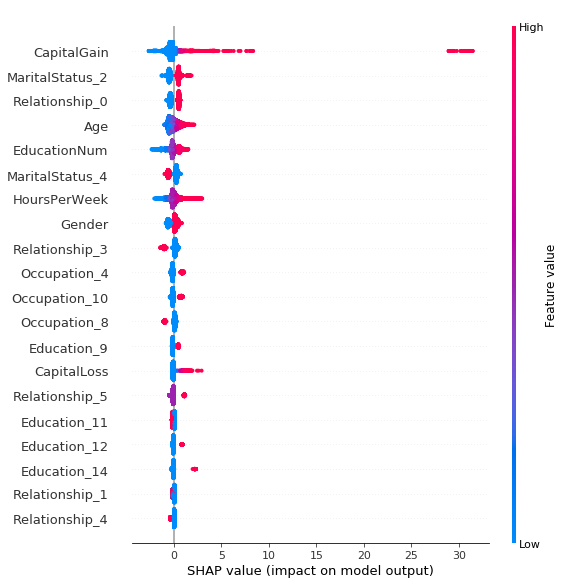

In [47]:
exp_transf_lr = shap.LinearExplainer(model_transf_lr, X_train_transf, feature_dependence="correlation")
shap_values_transf_lr = exp_transf_lr.shap_values(X_test_transf)
shap.summary_plot(shap_values_transf_lr, X_test_transf, feature_names=dataset.feature_names)

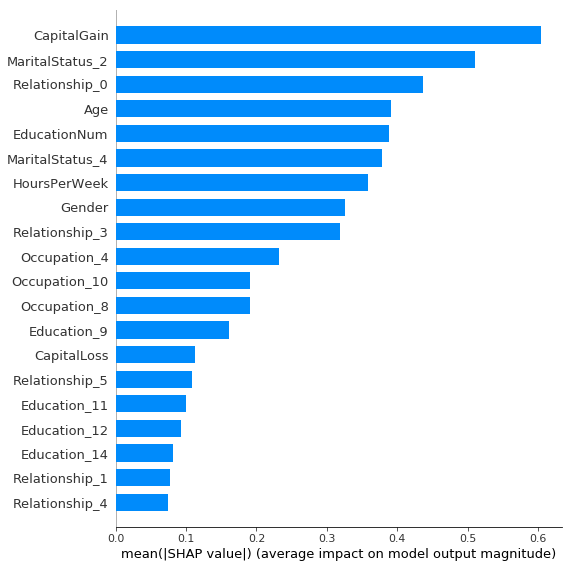

In [48]:
shap.summary_plot(shap_values_transf_lr, X_test_transf, feature_names=dataset.feature_names, plot_type="bar")

In [49]:
df_feat = pd.DataFrame({'feature_names': dataset.feature_names, 
                        'value': np.abs(shap_values_transf_lr).mean(axis=0)})
df_feat = df_feat.sort_values(by='value', ascending=False).reset_index(drop=True)
feat_import_transf_lr = df_feat.loc[df_feat['feature_names'] == name_protect, 'value'].iloc[0]
pos_transf_lr = df_feat[df_feat['feature_names'] == name_protect].index[0]
df_feat

,feature_names,value
0,CapitalGain,0.604030
1,MaritalStatus_2,0.510351
2,Relationship_0,0.437231
3,Age,0.390710
4,EducationNum,0.388030
5,MaritalStatus_4,0.378864
6,HoursPerWeek,0.358995
7,Gender,0.325952
8,Relationship_3,0.319389
9,Occupation_4,0.232592


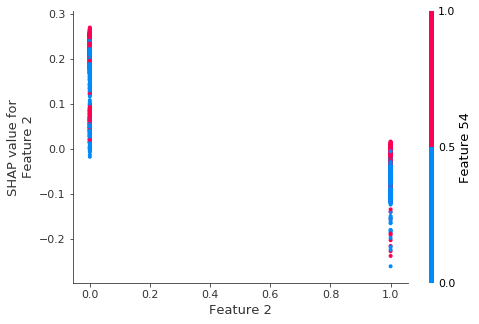

In [50]:
shap.dependence_plot(position, shap_values_transf_lr, dataset_test.features)

In [51]:
df = pd.DataFrame({'shap': shap_values_transf_lr[:, position], 
                   'feat_value': dataset_test.features[:, position]})
unp_value_transf_lr = df.loc[df['feat_value'] == 0, 'shap'].mean()
priv_value_transf_lr = df.loc[df['feat_value'] == 1, 'shap'].mean()
print('Media valores SHAP classe não priveligiada: ', unp_value_transf_lr)
print('Media valores SHAP classe priveligiada: ', priv_value_transf_lr)

Media valores SHAP classe não priveligiada:  0.18904258570174473
Media valores SHAP classe priveligiada:  -0.03200627357642337


In [52]:
results = stats.ttest_ind(df.loc[df['feat_value'] == 1, 'shap'], 
                          df.loc[df['feat_value'] == 0, 'shap'], equal_var=False)

alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad")
    priv_greater_unpriv = 1
else:
    print("accept null hypothesis")
    priv_greater_unpriv = 0

accept null hypothesis


In [0]:
lst_shape.append(('lr_transf', feat_import_transf_lr, pos_transf_lr,
                  unp_value_transf_lr, priv_value_transf_lr, priv_greater_unpriv))

Estimating transforms: 100%|██████████| 1000/1000 [00:28<00:00, 33.62it/s]


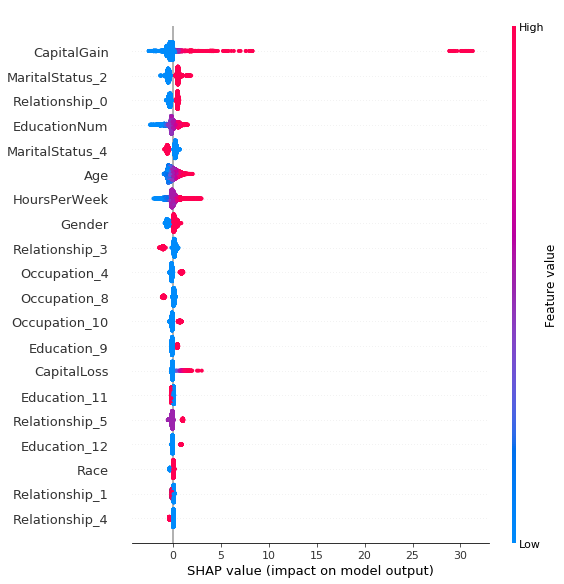

In [54]:
exp_orig_lr = shap.LinearExplainer(model_orig_lr, X_train_orig, feature_dependence="correlation")
shap_values_orig_lr = exp_orig_lr.shap_values(X_test_orig)
shap.summary_plot(shap_values_orig_lr, X_test_orig, feature_names=dataset.feature_names)

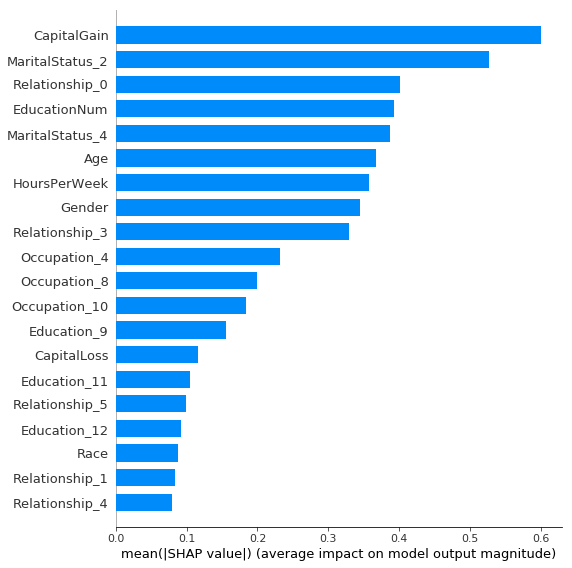

In [55]:
shap.summary_plot(shap_values_orig_lr, X_test_orig, feature_names=dataset.feature_names, plot_type="bar")

In [56]:
df_feat = pd.DataFrame({'feature_names': dataset.feature_names, 
                        'value': np.abs(shap_values_orig_lr).mean(axis=0)})
df_feat = df_feat.sort_values(by='value', ascending=False).reset_index(drop=True)
feat_import_orig_lr = df_feat.loc[df_feat['feature_names'] == name_protect, 'value'].iloc[0]
pos_orig_lr = df_feat[df_feat['feature_names'] == name_protect].index[0]
df_feat

,feature_names,value
0,CapitalGain,0.600008
1,MaritalStatus_2,0.526716
2,Relationship_0,0.401311
3,EducationNum,0.392076
4,MaritalStatus_4,0.386663
5,Age,0.367469
6,HoursPerWeek,0.357797
7,Gender,0.344503
8,Relationship_3,0.329753
9,Occupation_4,0.232025


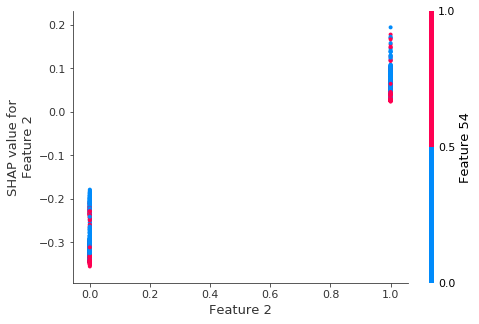

In [57]:
shap.dependence_plot(position, shap_values_orig_lr, dataset_test.features)

In [58]:
df = pd.DataFrame({'shap': shap_values_orig_lr[:, position], 
                   'feat_value': dataset_test.features[:, position]})
unp_value_orig_lr = df.loc[df['feat_value'] == 0, 'shap'].mean()
priv_value_orig_lr = df.loc[df['feat_value'] == 1, 'shap'].mean()
print('Media valores SHAP classe não priveligiada: ', unp_value_orig_lr)
print('Media valores SHAP classe priveligiada: ', priv_value_orig_lr)

Media valores SHAP classe não priveligiada:  -0.30251460921088996
Media valores SHAP classe priveligiada:  0.05115851148616775


In [59]:
results = stats.ttest_ind(df.loc[df['feat_value'] == 1, 'shap'], 
                          df.loc[df['feat_value'] == 0, 'shap'], equal_var=False)

alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad")
    priv_greater_unpriv = 1
else:
    print("accept null hypothesis")
    priv_greater_unpriv = 0

reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [0]:
lst_shape.append(('lr_orig', feat_import_orig_lr, pos_orig_lr,
                  unp_value_orig_lr, priv_value_orig_lr, priv_greater_unpriv))

In [61]:
prop_feat_import_lr = (feat_import_orig_lr - feat_import_transf_lr) / feat_import_orig_lr
print('Proporção diminuição da importancia: ', prop_feat_import_lr)

Proporção diminuição da importancia:  0.3735549451772705


In [62]:
df_shap = pd.DataFrame(lst_shape, columns=['name_exp', 'feat_imp', 'shap_rank', 
                                           'mean_unpriv', 'mean_priv', 'priv_greater_unpriv'])
df_final = pd.merge(df_shap, df_final, on='name_exp')
df_final

,name_exp,feat_imp,shap_rank,mean_unpriv,mean_priv,priv_greater_unpriv,dataset,acc_test,1_disp_impact_bin,mean_difference,1_disp_impact_clf,avg_odds,equal_opport,false_discovery_rate,entropy_index,consistency
0,rf_transf,0.004346,25,0.008077,-0.001521,0,adult,0.843484,0.419783,-0.094064,0.419783,-0.047351,-0.058014,0.035503,0.083505,0.881523
1,rf_orig,0.004276,24,0.008153,-0.001554,0,adult,0.843792,0.391354,-0.087600,0.391354,-0.036585,-0.041082,0.047609,0.083244,0.884983
2,lr_transf,0.055355,27,0.189043,-0.032006,0,adult,0.851162,0.173878,-0.035661,0.173878,0.057766,0.116239,0.089234,0.080638,0.935817
3,lr_orig,0.088364,17,-0.302515,0.051159,1,adult,0.852083,0.425055,-0.091517,0.425055,-0.041442,-0.048858,0.018721,0.079902,0.939953


In [0]:
df_final.to_csv(path + 'result/resultado_adult.csv')